In [1]:
import numpy as np
import pandas as pd

import conv_model as conv
import batch_hist as hist
import tensorflow as tf

In [2]:
#### User input ####

## path of the train and test data
train_data = "../data/digit-recognizer/train.csv"
test_data = "../data/digit-recognizer/test.csv"

In [3]:
## read data into Dataframe
df_train = pd.read_csv(train_data)
df_train.info()

df_test = pd.read_csv(test_data)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [4]:
## function to create input images
def create_input_images(df, start = 1):
    im_arr = []
    for row in range(0, len(df.index)):
        ## get the image values
        im_flat = np.array(df.iloc[row, start:])
        
        ## create the image frame
        image = np.reshape(im_flat, (28, 28, 1))
    
        im_arr.append(image)

    return np.array(im_arr, dtype = np.float32)

In [5]:
## create the arrays of input images
im_arr = create_input_images(df_train)
im_arr_test = create_input_images(df_test, start = 0)

In [6]:
from tensorflow.keras.losses import CategoricalCrossentropy

#### User input ####
learn_rate = 2.0e-3
epochs = 15
batch_size = 64
num_batches = int(im_arr.shape[0]/batch_size)

In [7]:
## create the model: simple convolutional layers
#model1 = conv.ConvModel(conv_layer = 'Conv2D', drop_rate = 0.25, kernel_size = (3, 3), filters = [48, 32])

## create the model: residual model layers
#model1 = conv.ResModel(drop_rate = 0.25, kernel_size = (3, 3), filters = [24, 48])

## create the model: large residual model with 2 x 6 layers
model1 = conv.ResModelLarge(drop_rate = 0.25, kernel_size = (3, 3))

##instantiate the batch callbacks
batch_history = hist.BatchHistory()

In [8]:
## initialize the adam optimizer with polynomial decay
poly_decay_rate = tf.keras.optimizers.schedules.PolynomialDecay(learn_rate, epochs)
#Adam_opt = tf.keras.optimizers.Adam(learning_rate = poly_decay_rate) ## with polynomial decay
Adam_opt = tf.keras.optimizers.Adam(learning_rate = learn_rate) ## without polynomial decay

## compile the model
model1.compile(optimizer = Adam_opt, loss = CategoricalCrossentropy(), metrics = ['accuracy'])

In [9]:
## create training input and one_hot encode
Y = df_train["label"].to_numpy()
Y_oh = tf.one_hot(Y, 10)
im_arr.shape

(42000, 28, 28, 1)

In [10]:
## fit the model (currently just testing the design, no final run yet)
model1.fit(im_arr, Y_oh, batch_size = batch_size, epochs = epochs, callbacks = [batch_history])

Epoch 1/15


2024-04-18 17:56:29.054813: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


657/657 [==============================] - 48s 71ms/step - loss: 0.4561 - accuracy: 0.9019
Epoch 2/15
657/657 [==============================] - 48s 74ms/step - loss: 0.0966 - accuracy: 0.9720
Epoch 3/15
657/657 [==============================] - 49s 75ms/step - loss: 0.0770 - accuracy: 0.9784
Epoch 4/15
657/657 [==============================] - 52s 79ms/step - loss: 0.0631 - accuracy: 0.9816
Epoch 5/15
657/657 [==============================] - 56s 85ms/step - loss: 0.0563 - accuracy: 0.9838
Epoch 6/15
657/657 [==============================] - 56s 85ms/step - loss: 0.0434 - accuracy: 0.9871
Epoch 7/15
657/657 [==============================] - 56s 86ms/step - loss: 0.0424 - accuracy: 0.9874
Epoch 8/15
657/657 [==============================] - 57s 86ms/step - loss: 0.0379 - accuracy: 0.9893
Epoch 9/15
657/657 [==============================] - 58s 89ms/step - loss: 0.0382 - accuracy: 0.9891
Epoch 10/15
657/657 [==============================] - 54s 83ms/step - loss: 0.0359 - accurac

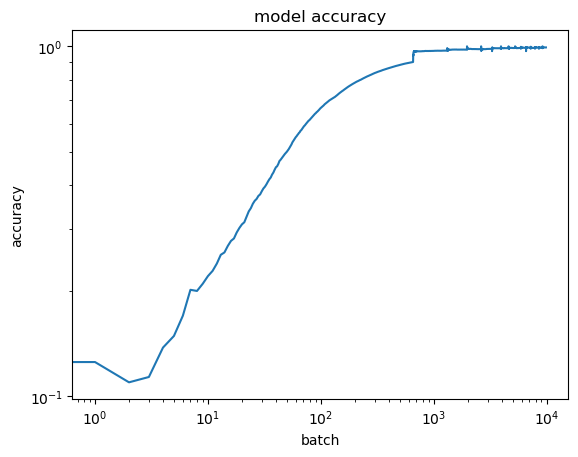

In [11]:
## plot the accuracy evolution during training
import matplotlib.pyplot as plt
plt.plot(batch_history.accuracies)
plt.title('model accuracy')

plt.xscale('log')
plt.yscale('log')

plt.ylabel('accuracy')
plt.xlabel('batch')

plt.show()

In [12]:
## print the model summary
#model1.summary()

In [ ]:
## predict for the test data
preds = model1.predict(im_arr_test)

840/875 [===========================>..] - ETA: 1s

In [ ]:
## add test predictions to the test dataframe
#print(preds.shape)
#print(len(np.argmax(preds, axis = 1)))
#print(len(np.arange(1, len(df_test.index)+1)))
#print(df_test.columns)

df_test["Label"] = np.argmax(preds, axis = 1)
df_test["ImageId"] = np.arange(1, len(df_test.index)+1)

In [ ]:
## path of the test predictions
#test_pred_path = "../data/digit-recognizer/test_preds12.csv"

## write results to csv file
#to_write = ["ImageId", "Label"]
#df_test.to_csv(test_pred_path, columns = to_write, index = False)